In [1]:
import pandas as pd

#biliotecas para extração e visualização do FFT ou Periodogram (PSD) 
import numpy as np
import matplotlib.pyplot as plt
#import pylab 
#from scipy import signal

import time # permite marcar o tempo de execução

In [308]:
start_time = time.time()

# reduz o samplig frequency 'ratio' vezes, tomando apenas 1 a cada 'ratio' sinais
ratio = 10
sampling_freq=50000/ratio # a ser usado no fft
skip=[i for i in range(0,250000) if i%ratio] # poupa apenas as linhas múltiplas de 'ratio' e lista as demais para exclusão

# dados no tempo
signals = pd.read_csv('..\mafaulda/imbalance/10g/61.8496.csv', header=None, 
                      names=['tacometro','ac1rad','ac1ax','ac1tg','ac2rad','ac2ax','ac2tg','microfone'],
                      skiprows=skip)
# reordenação das colunas
signals = signals[['tacometro','microfone','ac1rad','ac2rad','ac1tg','ac2tg','ac1ax','ac2ax']]

# transformada de Fourrier
signals_fft = signals.apply(np.fft.rfft, axis=0, norm="ortho")
signals_fft = signals_fft.apply(np.abs)
signals_fft['freq_ax'] = np.linspace(0, sampling_freq/2+1, signals_fft.shape[0]) # a frequência de Nyquist é sampling_freq/2

end_time = time.time()

print("Sinal com shape {} obtido em {} segundos".format(signals.shape, end_time-start_time))
print("a frequência de aquisição foi reduzida para {} kHz".format(sampling_freq/1000))

Sinal com shape (25000, 8) obtido em 0.23007416725158691 segundos
a frequência de aquisição foi reduzida para 5.0 kHz


tacometro     6.402000
microfone     1.321690
ac1rad        5.304800
ac2rad        0.543100
ac1tg         5.288200
ac2tg         7.048800
ac1ax        10.630500
ac2ax         0.175364
dtype: float64


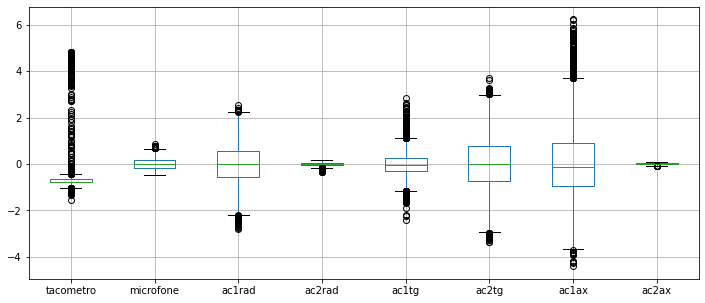

In [152]:
signals.boxplot(figsize=(12,5))
print(signals.max()-signals.min())
plt.show()

tacometro   -0.767615
microfone   -0.007653
ac1rad       0.006150
ac2rad       0.014439
ac1tg       -0.024868
ac2tg        0.017019
ac1ax       -0.130790
ac2ax        0.002572
dtype: float64


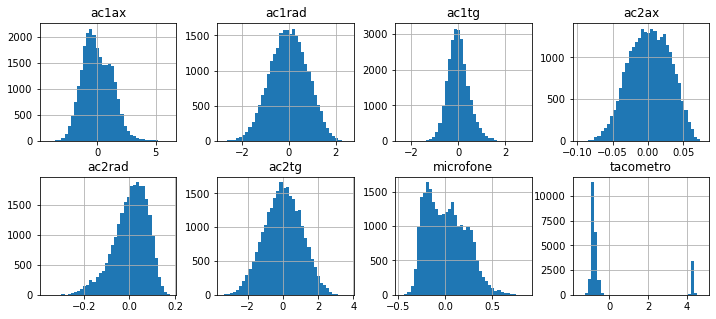

In [153]:
signals.hist(bins=40, figsize=(12,5), layout=(2,4))
print(signals.median())
plt.show()

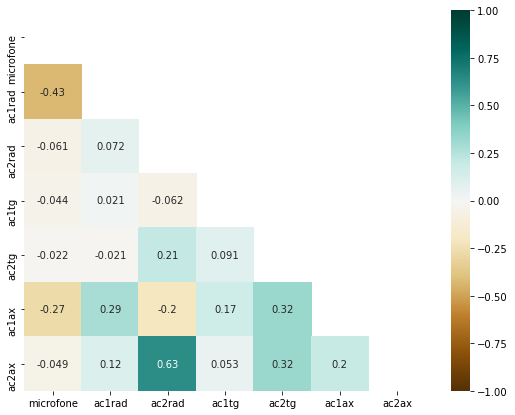

In [154]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(9,7)) 
corr = signals.iloc[:,1:].corr()

mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = 'BrBG', annot = True, mask = mask)
plt.show()

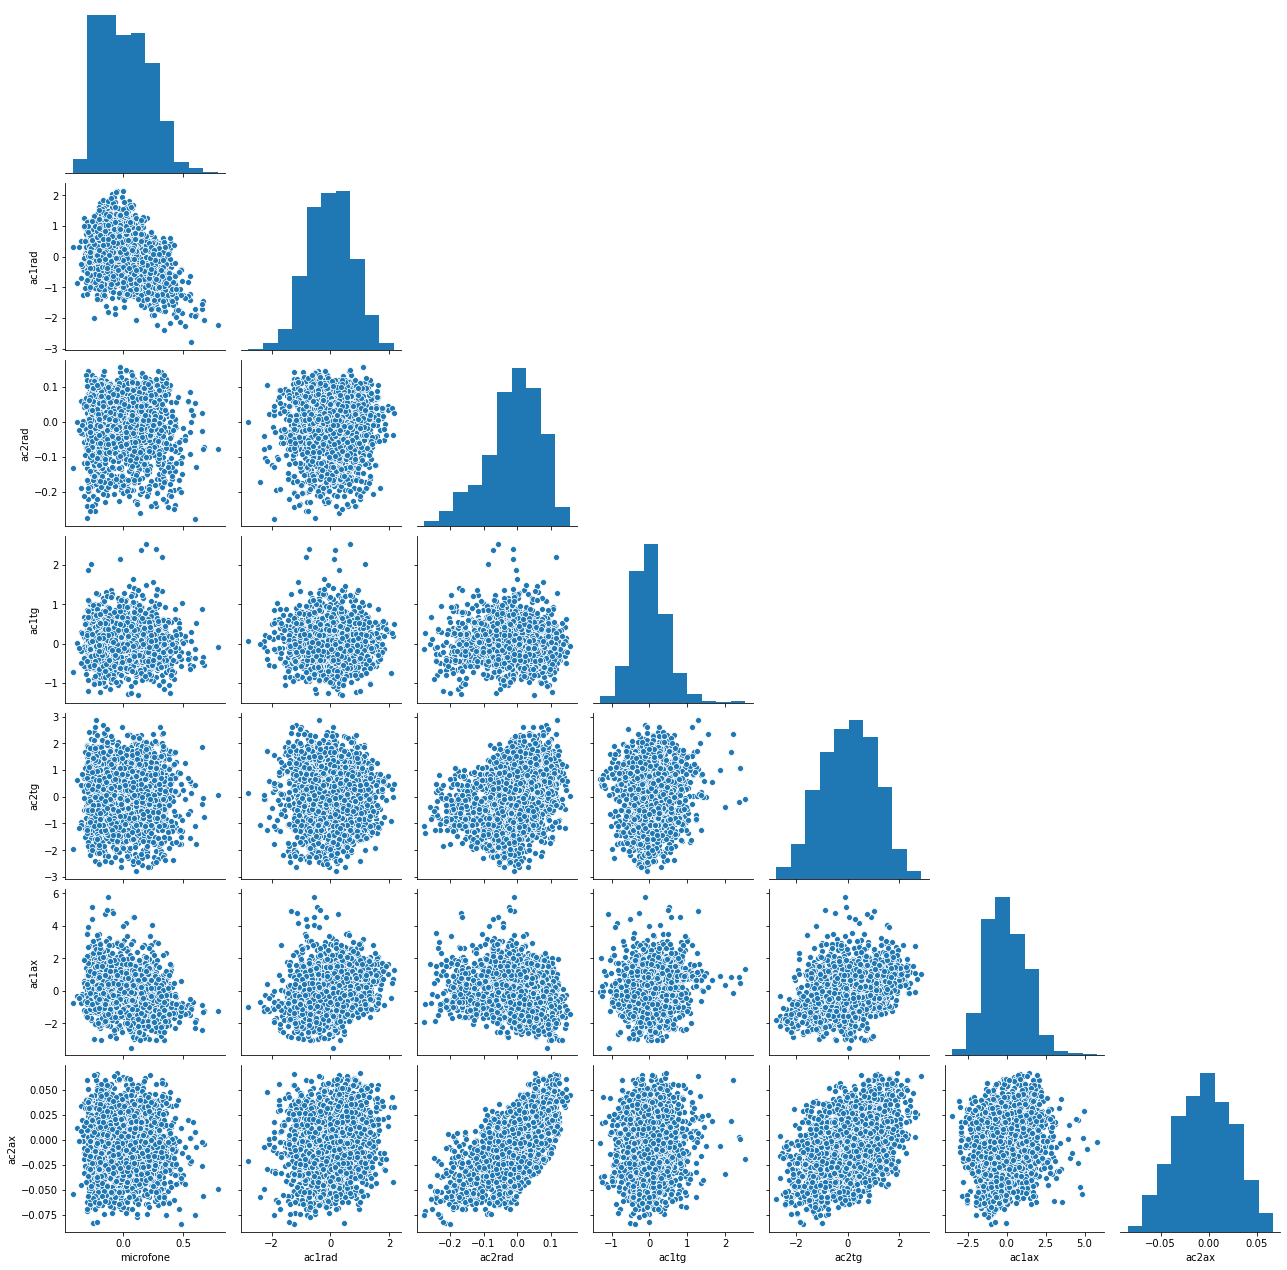

In [155]:
sns.pairplot(signals.iloc[:2000,1:], corner=True)
plt.show()

## Identificando e descrevendo os sinais (no tempo e na frequência)

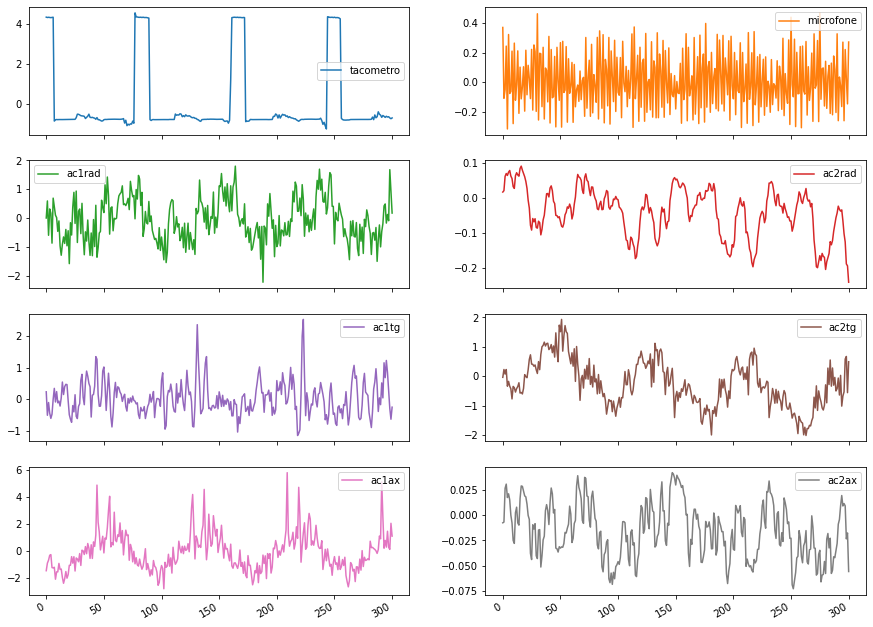

In [156]:
signals.loc[:300].plot(subplots=True, layout=(4,2), figsize=(15,12))
#signals.loc[:34].plot(subplots=True, layout=(2,4), figsize=(16,4))
plt.show()

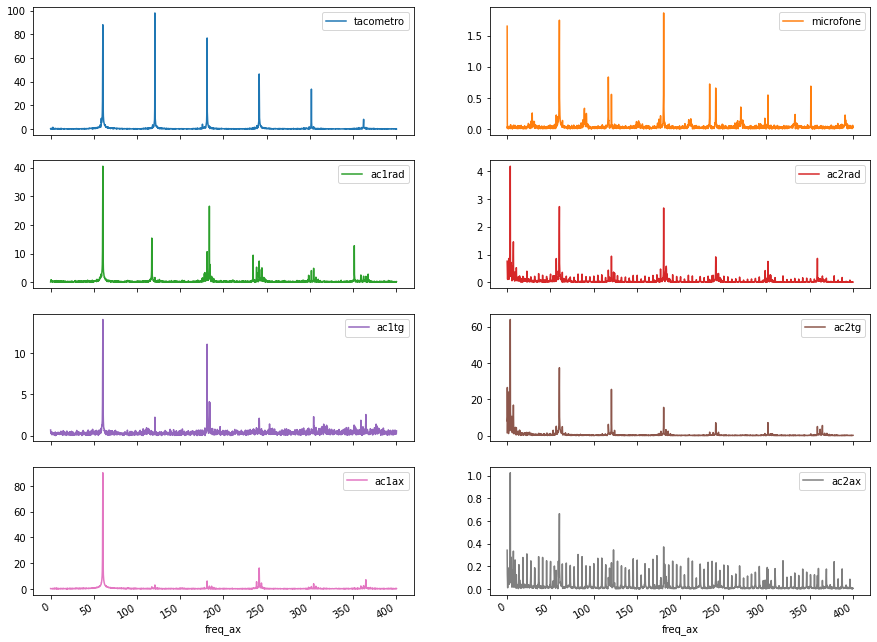

In [157]:
signals_fft.loc[:2000].plot(subplots=True, x='freq_ax', layout=(4,2), figsize=(15,12))
plt.show()

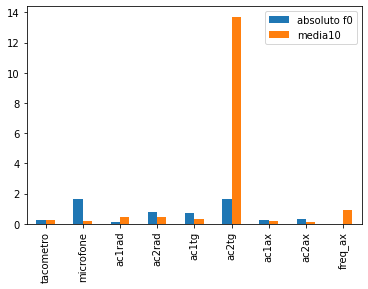

In [161]:
# identificando picos no FFT para f=0
absoluto = signals_fft.iloc[0]
absoluto.name='absoluto f0'
#nivelado = signals_fft.iloc[0].divide(signals_fft.iloc[:10].mean())
media10 = signals_fft.iloc[0:10].mean()
nivelado.name='media10'

pd.concat([absoluto, nivelado], axis=1).plot.bar()

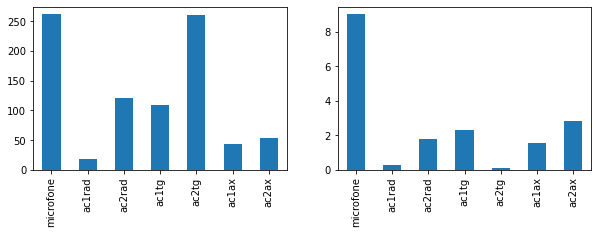

In [144]:
# identificando picos no FFT para f=0
absoluto = signals_fft.iloc[0]
nivelado = signals_fft.iloc[0].divide(signals_fft.iloc[:10].mean())

fig, axes = plt.subplots(1,2, figsize=(10, 3))
absoluto.plot.bar(ax=axes[0])
nivelado.plot.bar(ax=axes[1])
plt.show()

In [20]:
#import simpleaudio as sa
from IPython.display import Audio, display
for i, col in enumerate(signals_fft.columns.values[:-1]):
    print('som d@ {}'.format(col))
    display(Audio(signals[col], rate=1000))

som d@ tacometro


som d@ microfone


som d@ ac1rad


som d@ ac2rad


som d@ ac1ax


som d@ ac2ax


som d@ ac1tg


som d@ ac2tg


# Extraindo características na frequência

In [309]:
#obtenção do valor da fundamental
fft_df = signals_fft['tacometro'].copy()
candidates = [0, 0, 0]
for i in range(3):
    index = fft_df.argmax()
    candidates[i] = signals_fft.freq_ax[index]
    for j in range(-2,3):
        fft_df[index+j] = 0
        
fundamental = min(candidates)
fundamental

60.42416

In [310]:
# extraindo valores no primeiro harmônico
index = signals_fft.index[signals_fft['freq_ax'] == fundamental]
print(index)
print('  Fundamental: {}\n2xFundamental: {}\n'.format(fundamental, 2*fundamental))

# acesso aos harmônicos, basta multiplicar o index
print(signals_fft.iloc[index,-1], '\n')
print(signals_fft.iloc[2*index,-1])

Int64Index([302], dtype='int64')
  Fundamental: 60.42416
2xFundamental: 120.84832

302    60.42416
Name: freq_ax, dtype: float64 

604    120.84832
Name: freq_ax, dtype: float64


### Hamônicas - Implementação ingênua

In [311]:
def extract_n_harmonics_naive(fft_df, fund_index, n_harmonics=3):
    #protege o DataFrame original de alterações
    fft_df = fft_df.copy()
    
    # extrai todos os valores nos primeiros n harmônicos, exceto para o tacômetro e freq_ax
    fft_df.pop('tacometro')
    fft_df.pop('freq_ax')

    harmonic_features = {}
    for i in range(n_harmonics+1):
        # resgata no DataFrame os valores na harmonica i
        harm_values = fft_df.iloc[fund_index * i].to_dict('records')[0]
        
        # adiciona às features com o respectivo sulfixo do harmonico i
        harmonic_features.update({k+'_{}h'.format(i): v for k, v in harm_values.items()})

    return harmonic_features

extract_n_harmonics_naive(signals_fft, index, 3)

{'microfone_0h': 1.6506406695173204,
 'ac1rad_0h': 0.11853375984069707,
 'ac2rad_0h': 0.7615562233822849,
 'ac1tg_0h': 0.6872322526429525,
 'ac2tg_0h': 1.6425833093111193,
 'ac1ax_0h': 0.2746528561169272,
 'ac2ax_0h': 0.34218467418145154,
 'microfone_1h': 1.747025931297273,
 'ac1rad_1h': 40.508566790485034,
 'ac2rad_1h': 2.730376495560166,
 'ac1tg_1h': 14.079508197172173,
 'ac2tg_1h': 37.39370677336478,
 'ac1ax_1h': 90.2301309263882,
 'ac2ax_1h': 0.6647914417222536,
 'microfone_2h': 0.15099914124183364,
 'ac1rad_2h': 0.874677634627383,
 'ac2rad_2h': 0.24393493878016553,
 'ac1tg_2h': 0.35777570799437275,
 'ac2tg_2h': 6.490237698969767,
 'ac1ax_2h': 0.680649189668766,
 'ac2ax_2h': 0.048886517549134846,
 'microfone_3h': 0.3621555708226454,
 'ac1rad_3h': 2.49004460375138,
 'ac2rad_3h': 0.43075699250376365,
 'ac1tg_3h': 2.3403436636451294,
 'ac2tg_3h': 2.8618405144337036,
 'ac1ax_3h': 1.0212133797519052,
 'ac2ax_3h': 0.06724460039810229}

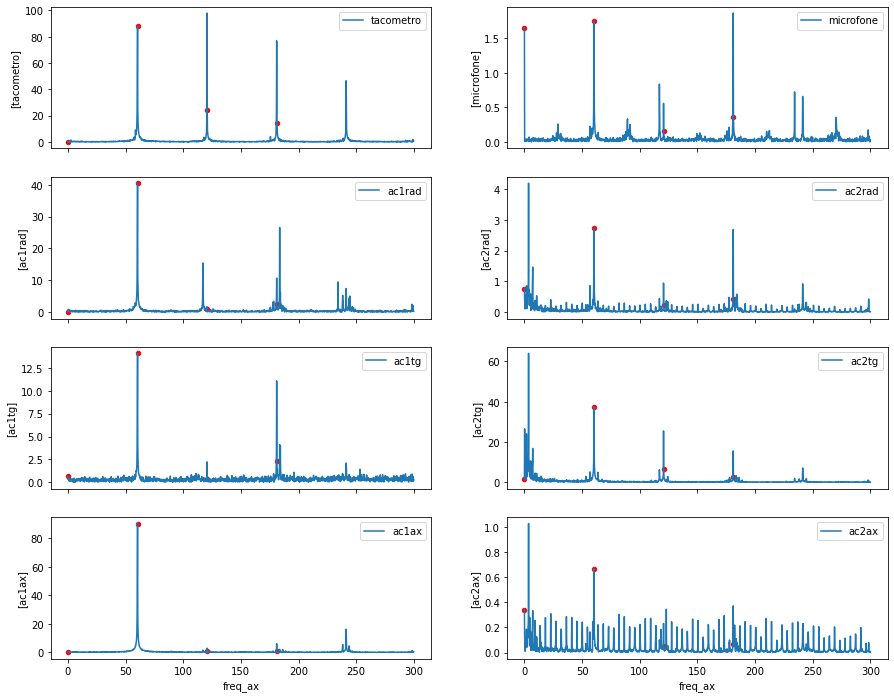

In [312]:
fig, axes = plt.subplots(4,2,figsize=(15, 12),sharex=True)

nindex = index[0]
harmonic_values = signals_fft.iloc[[0, nindex, nindex*2, nindex*3]]

for i, col in enumerate(signals_fft.columns.values[:-1]):
    signals_fft[:1500].plot(x='freq_ax', y=[col], ax=axes[i//2,i%2])
    harmonic_values.plot(x='freq_ax', y=[col], ax=axes[i//2,i%2], kind='scatter', color="red")
    
plt.show()

### Hamônicas - Implementação robusta

In [358]:
def extract_n_harmonics_naive(fft_df, fund_index, n_harmonics=3):
    #protege o DataFrame original de alterações
    fft_df = fft_df.copy()
    
    # extrai todos os valores nos primeiros n harmônicos, exceto para o tacômetro e freq_ax
    fft_df.pop('tacometro')
    fft_df.pop('freq_ax')

    harmonic_features = {}
    idx = fund_index[0]
    for i in range(n_harmonics+1):
        # resgata no DataFrame os valores na harmonica i
        if i:
            harm_values = fft_df.iloc[idx*i-10:idx*i+11].max()
        else:
            harm_values = fft_df.iloc[0]
        harm_values = harm_values.to_dict()
        
        # adiciona às features com o respectivo sulfixo do harmonico i
        harmonic_features.update({k+'_{}h'.format(i): v for k, v in harm_values.items()})

    return harmonic_features

extract_n_harmonics_naive(signals_fft, index, 3)

{'microfone_0h': 1.6506406695173204,
 'ac1rad_0h': 0.11853375984069707,
 'ac2rad_0h': 0.7615562233822849,
 'ac1tg_0h': 0.6872322526429525,
 'ac2tg_0h': 1.6425833093111193,
 'ac1ax_0h': 0.2746528561169272,
 'ac2ax_0h': 0.34218467418145154,
 'microfone_1h': 1.747025931297273,
 'ac1rad_1h': 40.508566790485034,
 'ac2rad_1h': 2.730376495560166,
 'ac1tg_1h': 14.079508197172173,
 'ac2tg_1h': 37.39370677336478,
 'ac1ax_1h': 90.2301309263882,
 'ac2ax_1h': 0.6647914417222536,
 'microfone_2h': 0.5570434383652646,
 'ac1rad_2h': 1.6817630087875526,
 'ac2rad_2h': 0.9425320253363267,
 'ac1tg_2h': 2.2325865290876523,
 'ac2tg_2h': 25.46998347356952,
 'ac1ax_2h': 3.0098243593448553,
 'ac2ax_2h': 0.2312774004317455,
 'microfone_3h': 1.863014097833338,
 'ac1rad_3h': 10.692158694845476,
 'ac2rad_3h': 2.679978949109905,
 'ac1tg_3h': 11.076052884975862,
 'ac2tg_3h': 15.55107828991699,
 'ac1ax_3h': 6.115548520557183,
 'ac2ax_3h': 0.37124666909082876}

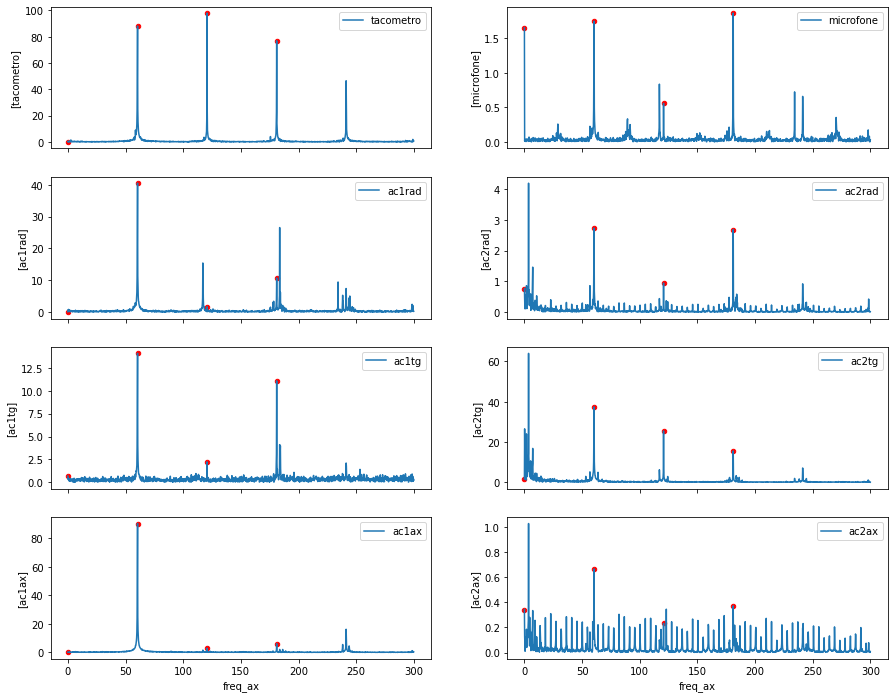

In [357]:
fig, axes = plt.subplots(4,2,figsize=(15, 12),sharex=True)

idx = index[0]
harmonic_values = signals_fft.iloc[0].to_frame().T

for i in range(1,4):
    # resgata no DataFrame os valores na harmonica i
    harmonic_values = harmonic_values.append(signals_fft.iloc[idx*i-10:idx*i+11].max(), ignore_index=True)
    harmonic_values.iloc[-1]['freq_ax'] = fundamental*i
#     harmonic_values = pd.concat([harmonic_values, signals_fft.iloc[idx*i-4:idx*i+5].max()], axis=1)

harmonic_values
for i, col in enumerate(signals_fft.columns.values[:-1]):
    signals_fft[:1500].plot(x='freq_ax', y=[col], ax=axes[i//2,i%2])
    harmonic_values.plot(x='freq_ax', y=[col], ax=axes[i//2,i%2], kind='scatter', color="red")
    
plt.show()

## Máquina de análise de FFT

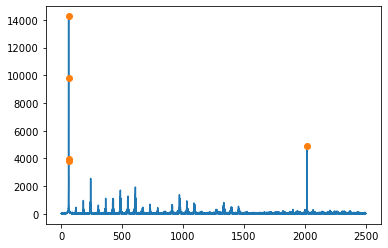

,freq,harmonic,amplitude
4,60.024,0.993,"3,800.319"
1,60.224,0.997,"9,798.210"
0,60.424,1.000,"14,266.636"
3,60.624,1.003,"3,958.817"
2,"2,020.408",33.437,"4,882.395"


In [33]:
real_fft = signals_fft['ac1ax'].values

num_max = 5 # limiar de seleção
temp = np.argpartition(-real_fft, num_max) # ordenando parte dos sinais
biggest_args = temp[:num_max] # extraindo os índices dos maiores valores de amplitude

greatest_values = pd.DataFrame({'freq':signals_fft.freq_ax[biggest_args], 
                                'harmonic': signals_fft.freq_ax[biggest_args]/fundamental,
                                'amplitude':real_fft[biggest_args]})

greatest_values.sort_values('amplitude', ascending=False, ignore_index=True, inplace=True) # organiza os índices decrescendo 
                                                                                           # amplitude do sinal

pd.options.display.float_format = '{:,.3f}'.format


# plot com zoom
max_freq = 3000
plt.plot(signals_fft.freq_ax[:max_freq*5], real_fft[:max_freq*5], 
         list(greatest_values['freq']), list(greatest_values['amplitude']), 'o')
plt.show()

# mostra tabela
greatest_values.sort_values('harmonic') # exibe na ordem de HARMONICOS crescentes
#greatest_values  # exibe na ordem de AMPLITUDES decrescentes

# Extração de dados estatísticos

### Entropia

In [ ]:
import scipy.stats as stats

In [452]:
step = 0.2
bin_range = np.arange(-10, 10+step, step)

out  = pd.cut(signals['ac2tg'], bins = bin_range, include_lowest=True, right=False, retbins=True)[0]
out
out.value_counts(sort=False).head()
out.value_counts(sort=False).values
# out.value_counts(sort=False).plot.bar()

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          5,    9,   33,   51,  112,  200,  298,  415,  560,  742,  933,
       1108, 1255, 1447, 1582, 1710, 1889, 1774, 1766, 1637, 1504, 1419,
       1196,  960,  774,  556,  420,  246,  188,  114,   59,   22,   11,
          3,    0,    2,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int64)

In [453]:
# len(out.value_counts().values)
stats.entropy(out.value_counts())

3.077747979983247

In [468]:
# para todos
step = 0.2
bin_range = np.arange(-10, 10+step, step)

entropias = {}
for i, col in enumerate(signals.columns.values[:]):
    out = pd.cut(signals[col], bins = bin_range, include_lowest=True, right=False, retbins=True)[0]
    entropias[col] = stats.entropy(out.value_counts())

entropias = {k+'_entropy':v for k,v in entropias.items()}
entropias

{'tacometro_entropy': 1.2803855122718628,
 'microfone_entropy': 1.47186701183248,
 'ac1rad_entropy': 2.7979815230666016,
 'ac2rad_entropy': 0.7328144428019492,
 'ac1tg_entropy': 2.229196751970786,
 'ac2tg_entropy': 3.077747979983247,
 'ac1ax_entropy': 3.249561363289862,
 'ac2ax_entropy': 0.6914268690428652}

### Média

In [464]:
medias = signals.mean().to_dict()
medias = {k+'_mean': v for k,v in medias.items()}
medias

{'tacometro_mean': 0.0014981384799999922,
 'microfone_mean': 0.010439568228359985,
 'ac1rad_mean': 0.00074967332143999,
 'ac2rad_mean': 0.004816504464327978,
 'ac1tg_mean': 0.004346438399760035,
 'ac2tg_mean': 0.010388609007999894,
 'ac1ax_mean': -0.0017370571824000013,
 'ac2ax_mean': 0.002164165901632015}

### Curtose

In [467]:
curtoses = signals.kurtosis().to_dict()
curtoses = {k+'_kurt':v for k, v in curtoses.items()}
curtoses

{'tacometro_kurt': 1.752723596332189,
 'microfone_kurt': -0.5111046991919062,
 'ac1rad_kurt': -0.2568646495687834,
 'ac2rad_kurt': 0.3783044601290495,
 'ac1tg_kurt': 1.106557961081704,
 'ac2tg_kurt': -0.33595533358365026,
 'ac1ax_kurt': 0.3119267769626135,
 'ac2ax_kurt': -0.5757275085644031}

In [475]:
time_statistics = entropias
time_statistics.update(medias)
time_statistics.update(curtoses)
time_statistics

{'tacometro_entropy': 1.2803855122718628,
 'microfone_entropy': 1.47186701183248,
 'ac1rad_entropy': 2.7979815230666016,
 'ac2rad_entropy': 0.7328144428019492,
 'ac1tg_entropy': 2.229196751970786,
 'ac2tg_entropy': 3.077747979983247,
 'ac1ax_entropy': 3.249561363289862,
 'ac2ax_entropy': 0.6914268690428652,
 'tacometro_mean': 0.0014981384799999922,
 'microfone_mean': 0.010439568228359985,
 'ac1rad_mean': 0.00074967332143999,
 'ac2rad_mean': 0.004816504464327978,
 'ac1tg_mean': 0.004346438399760035,
 'ac2tg_mean': 0.010388609007999894,
 'ac1ax_mean': -0.0017370571824000013,
 'ac2ax_mean': 0.002164165901632015,
 'tacometro_kurt': 1.752723596332189,
 'microfone_kurt': -0.5111046991919062,
 'ac1rad_kurt': -0.2568646495687834,
 'ac2rad_kurt': 0.3783044601290495,
 'ac1tg_kurt': 1.106557961081704,
 'ac2tg_kurt': -0.33595533358365026,
 'ac1ax_kurt': 0.3119267769626135,
 'ac2ax_kurt': -0.5757275085644031}

## Teste: Análise de séries temporais

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [35]:
period = int(round(sampling_freq/fundamental))
period

83

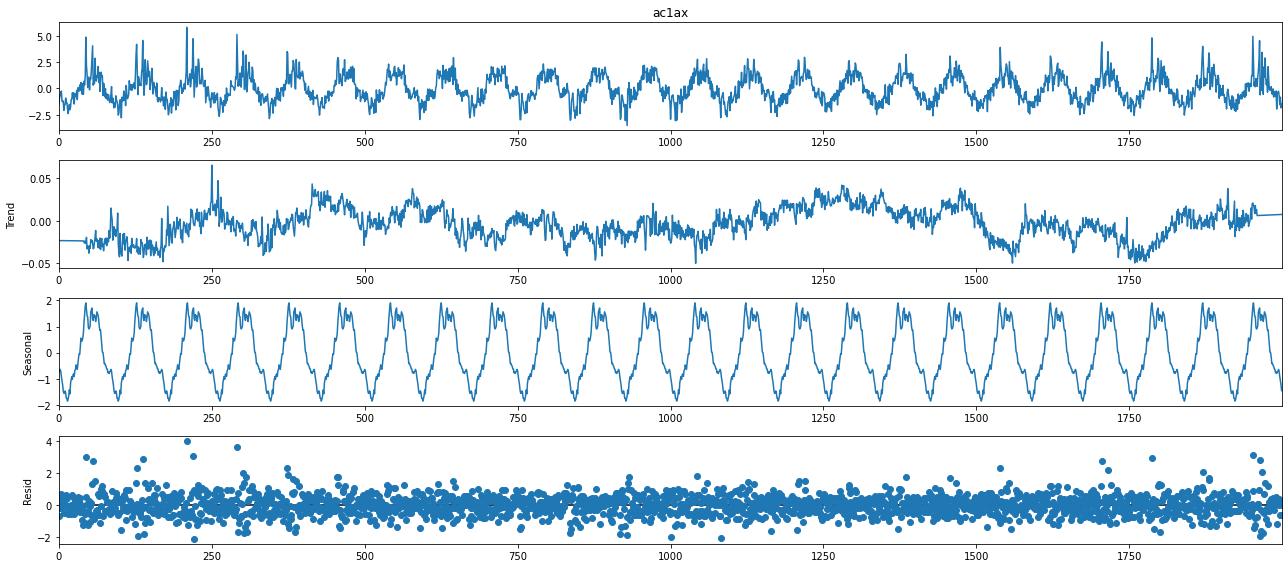

In [39]:
decomp_aditiva = seasonal_decompose(signals['ac1ax'][:2000], period=period, model='additive', extrapolate_trend='freq')
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomp_aditiva.plot()
plt.show()

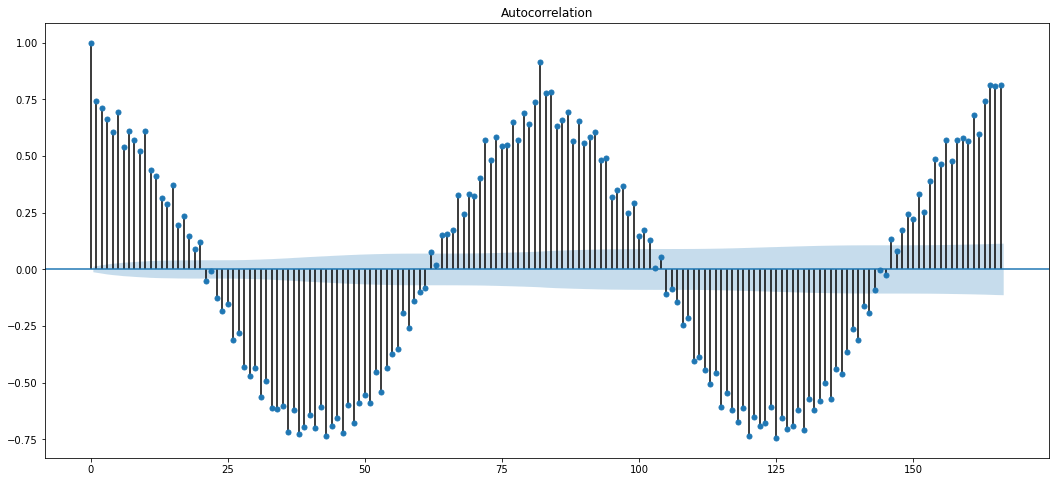

In [38]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(signals['ac1ax'], lags=2*period)
plt.show()

conclusão parcial: não dá para afirmar nada com modelos de séries temporais com sazonalidade